In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import f90nml
from salishsea_tools import metric_tools as met

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [2]:
reference_namelist_file = '/data/jpetrie/MEOPAR/SS-run-sets/SS-SMELT/namelists/namelist_pisces_cfg_5x5_NewIC'
reference_bio_params = f90nml.read(reference_namelist_file)

In [3]:
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'

param_metrics = pd.DataFrame()

batch_directories = [
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampiszoo_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampisopt_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampismes_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampissink_june_17/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampisprod_june_16/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampismort_june_17/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampisrem_june_17/',
    
]

metric_func_list = [
                    met.mean_NH4_at_depth,
                    met.mean_NO3_at_depth,
                    met.mean_DON_at_depth,
                    met.mean_PON_at_depth,
                    met.time_of_peak_PHY2,
                    met.time_surface_NO3_drops_below_4,
]

for batch_dir in batch_directories:
    for file in os.listdir(batch_dir):
        if os.path.isfile(batch_dir + '/' + file + '/' + tracer_file) and 'zz_frac_waste' not in file:
            last_underscore = file.rfind('_')
            first_underscore = file.find('_')
            param_name = file[:last_underscore]
            param_val = float(file[(last_underscore+1):])
            param_scale = round(param_val/reference_bio_params[file[:first_underscore]][file[(first_underscore+1):last_underscore]], 3)
            grid_t = xr.open_dataset(batch_dir + '/' + file +'/' + tracer_file)
            
            for metric_func in metric_func_list:
                metric_val = metric_func(grid_t)
                metric_name = metric_func.__name__
                # inefficient to keep appending, but much less expensive than other parts of the loop so it doesn't matter
                param_metrics = param_metrics.append(pd.DataFrame({"PARAM_NAME":[param_name], "PARAM_VAL":[param_val],"PARAM_SCALE":[param_scale], "METRIC_NAME":[metric_name], "METRIC_VAL": [metric_val]}))

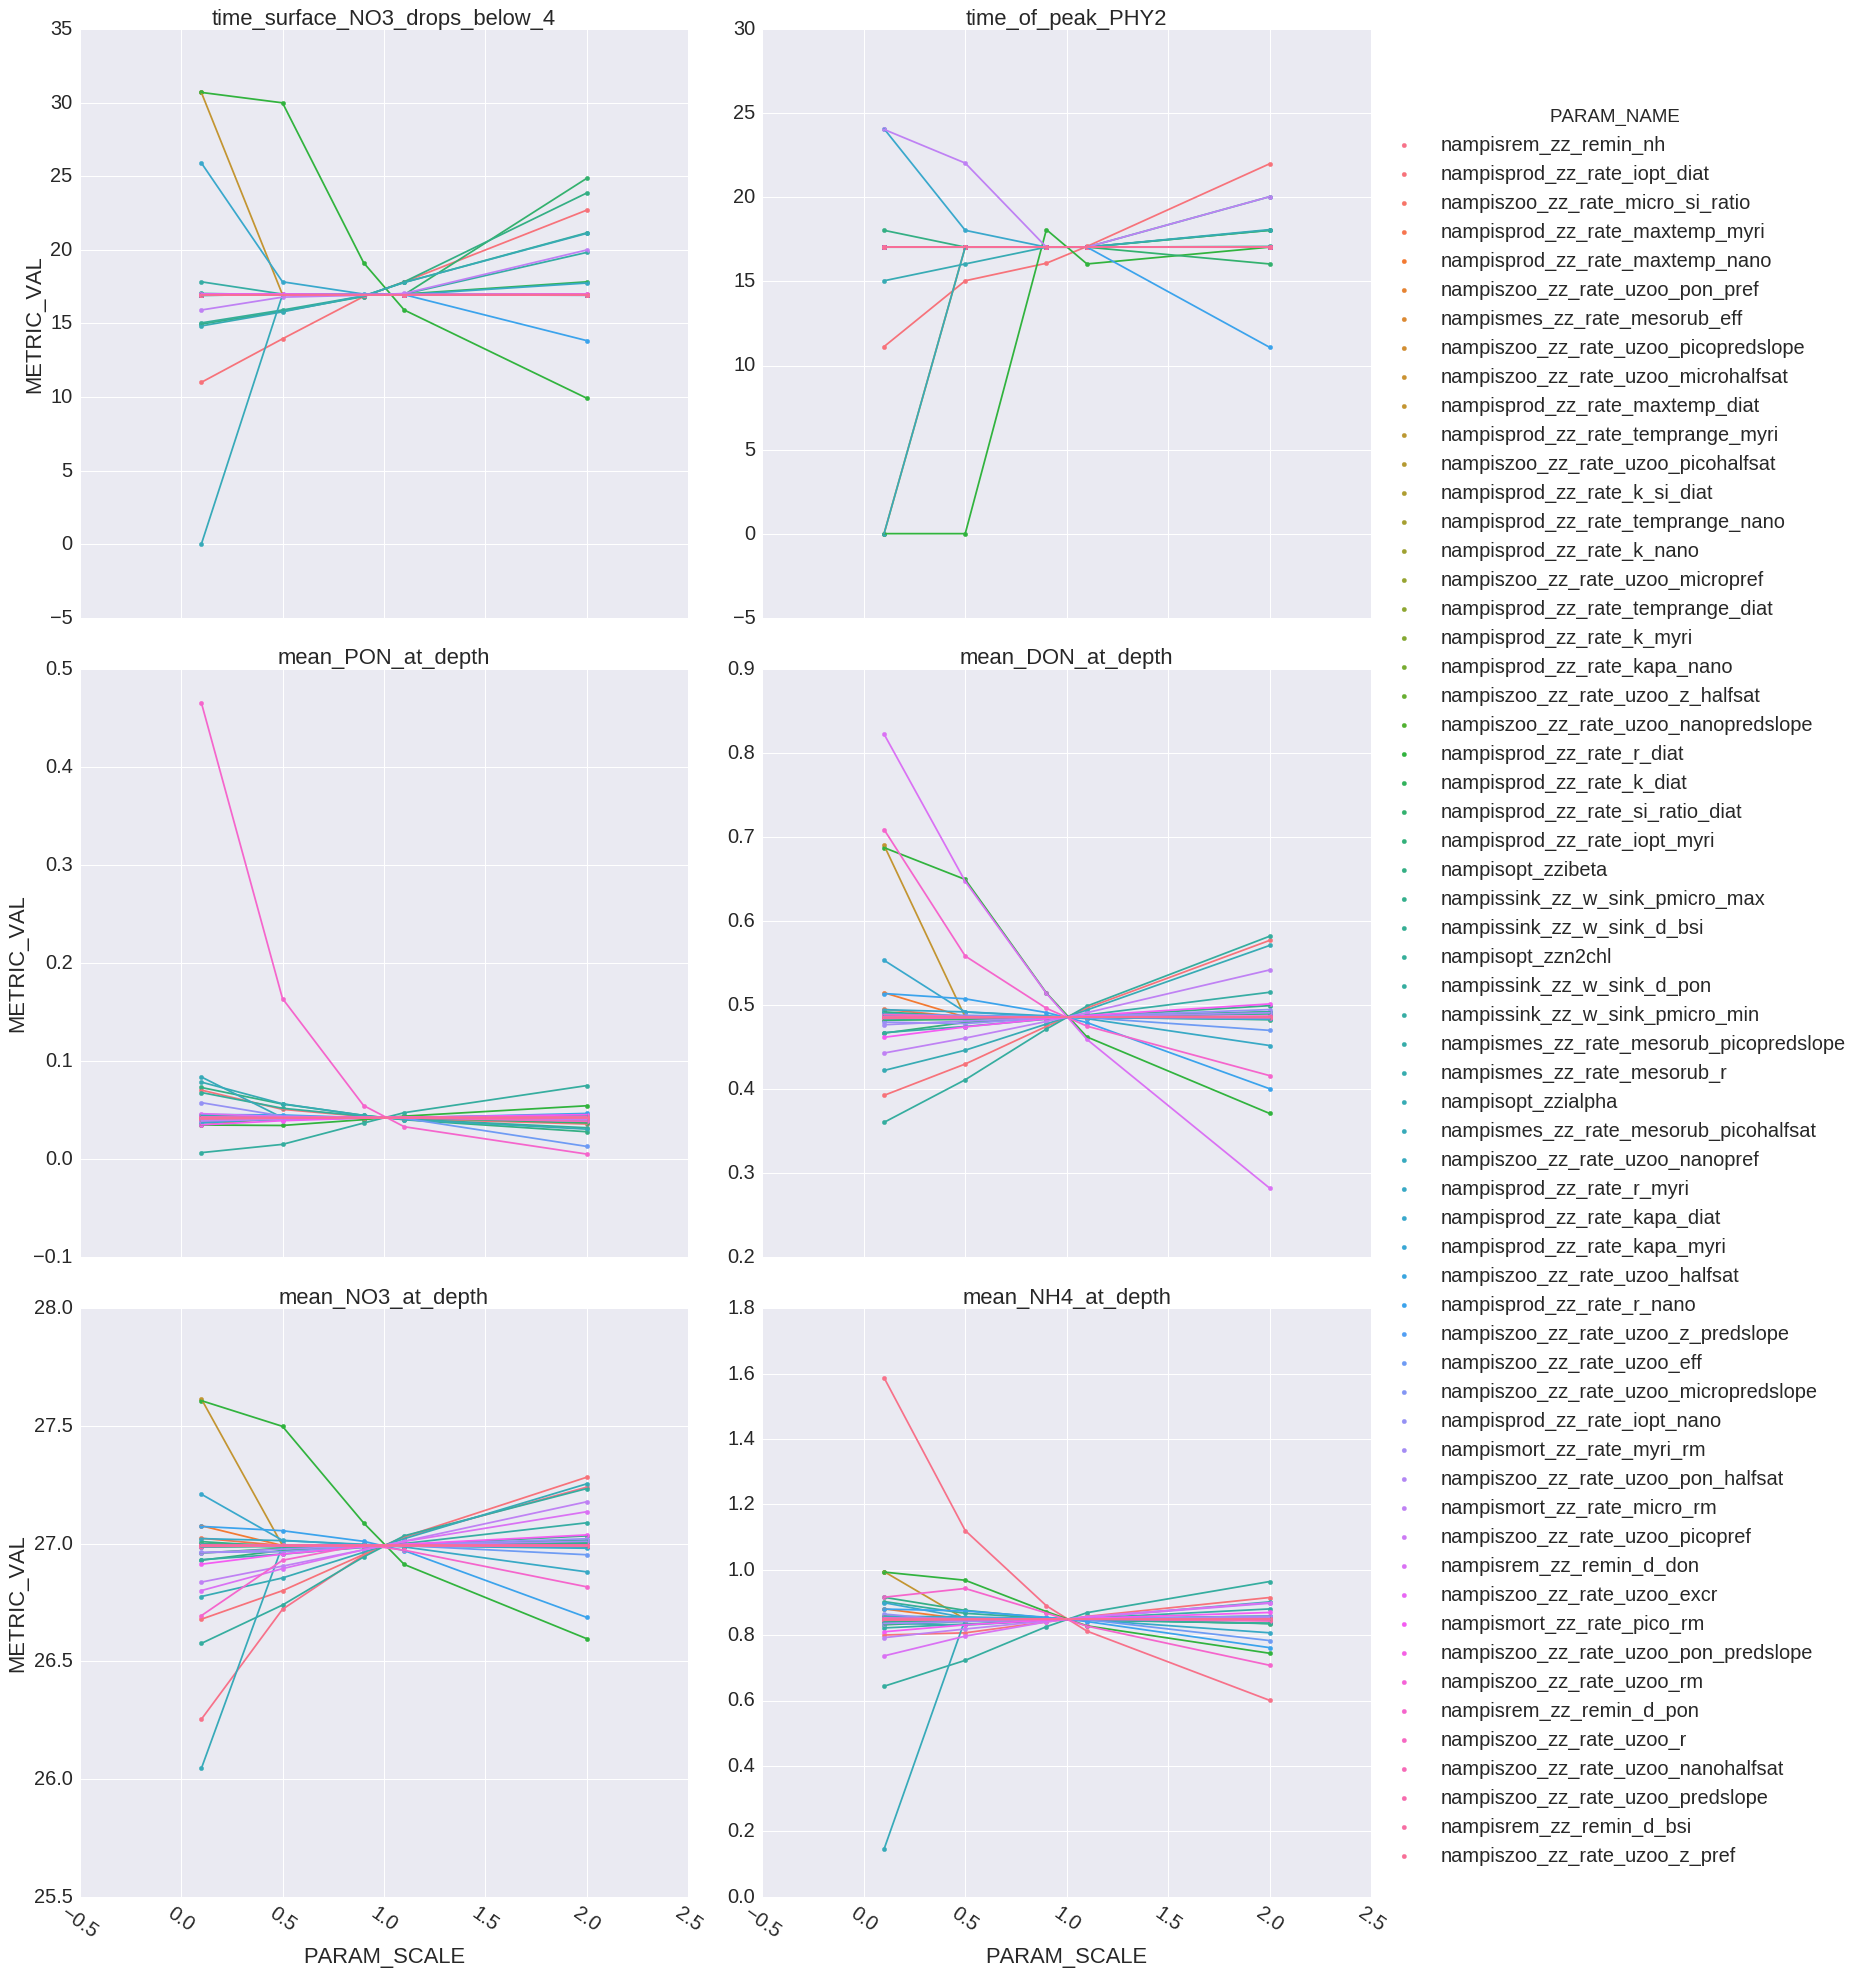

In [4]:
sns.set(font_scale = 2)
plt.rcParams['image.cmap'] = 'jet'

param_metrics = param_metrics.sort_values("PARAM_SCALE")

fg = sns.FacetGrid(data=param_metrics.query("PARAM_SCALE < 10"), col = "METRIC_NAME", hue = "PARAM_NAME",  sharey=False, col_wrap = 2, size = 10)
fg.map(plt.scatter, "PARAM_SCALE", "METRIC_VAL")
fg.map(plt.plot, "PARAM_SCALE", "METRIC_VAL").add_legend()
fg.set_xticklabels(rotation=-35)
plt.subplots_adjust(top=0.9)
#fg.set(xlim=(0, max(param_vals)))
fg.set_titles("{col_name}")

In [5]:
wide_format_metrics = pd.pivot_table(param_metrics, values='METRIC_VAL', index=['PARAM_NAME', 'METRIC_NAME'], columns=['PARAM_SCALE'])
wide_format_metrics.reset_index(inplace=True)
wide_format_metrics["SLOPE"] = (wide_format_metrics[1.1] - wide_format_metrics[0.9])/0.2
wide_format_metrics["PARAM_SECTION"] = wide_format_metrics['PARAM_NAME'].str.split("_").str.get(0)

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


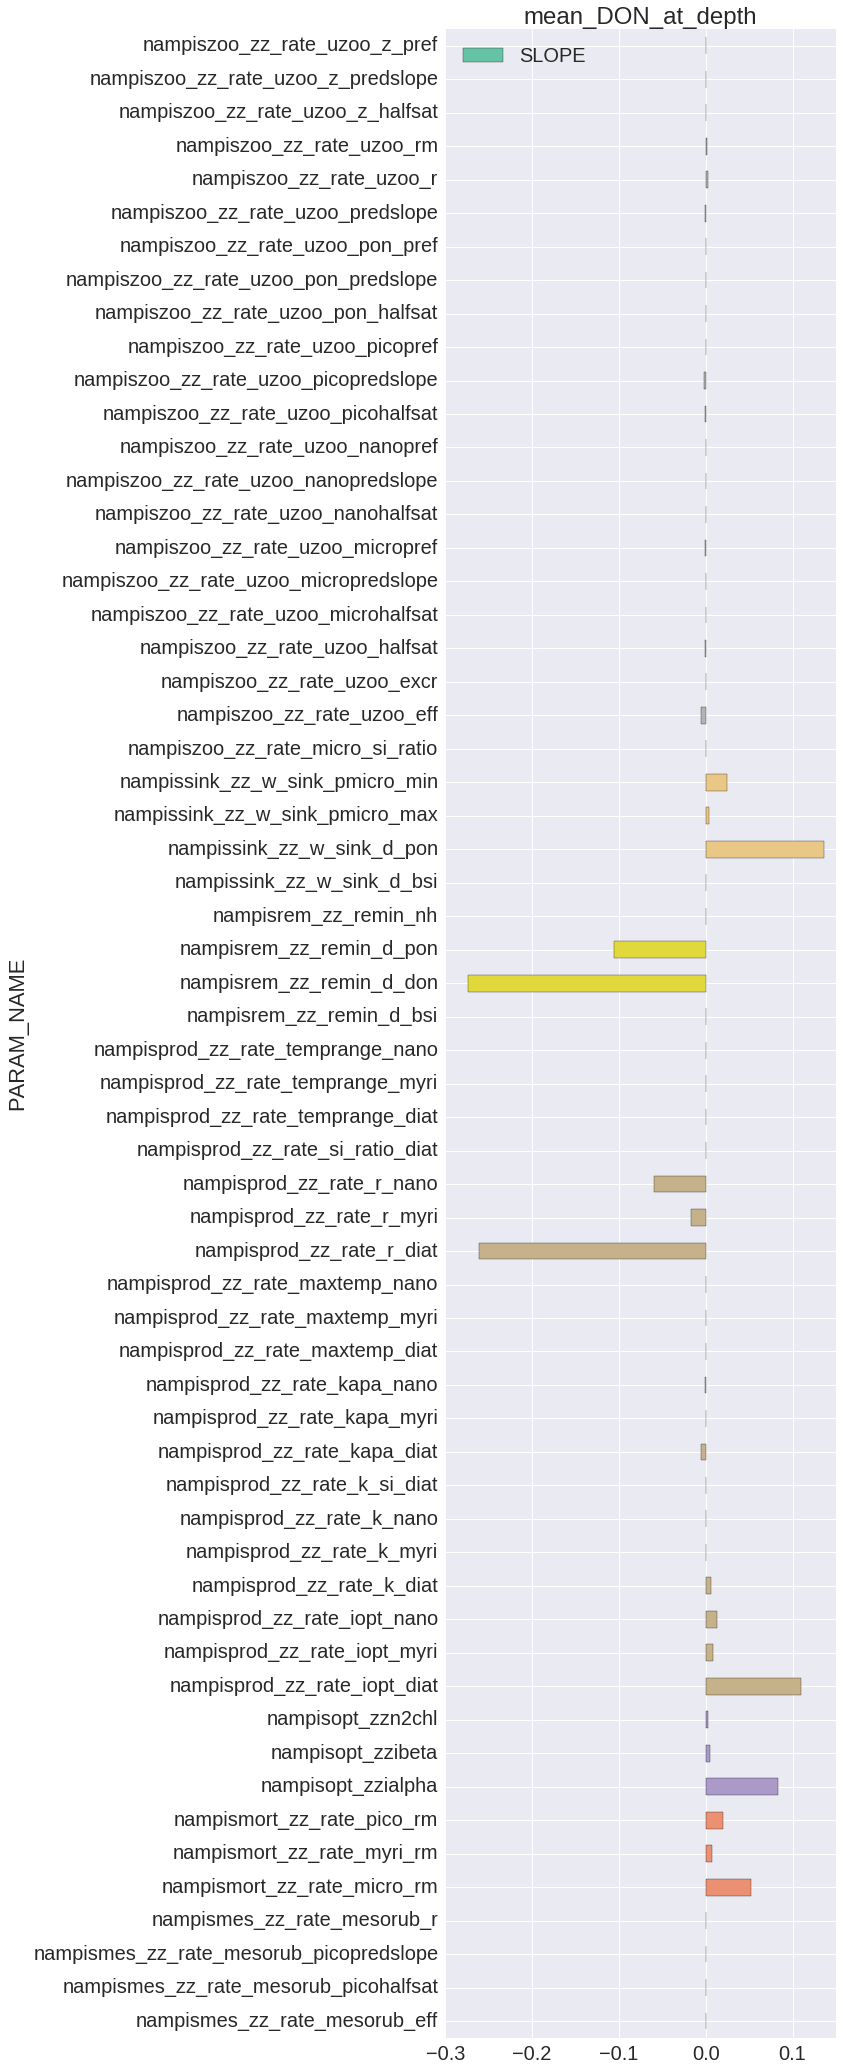

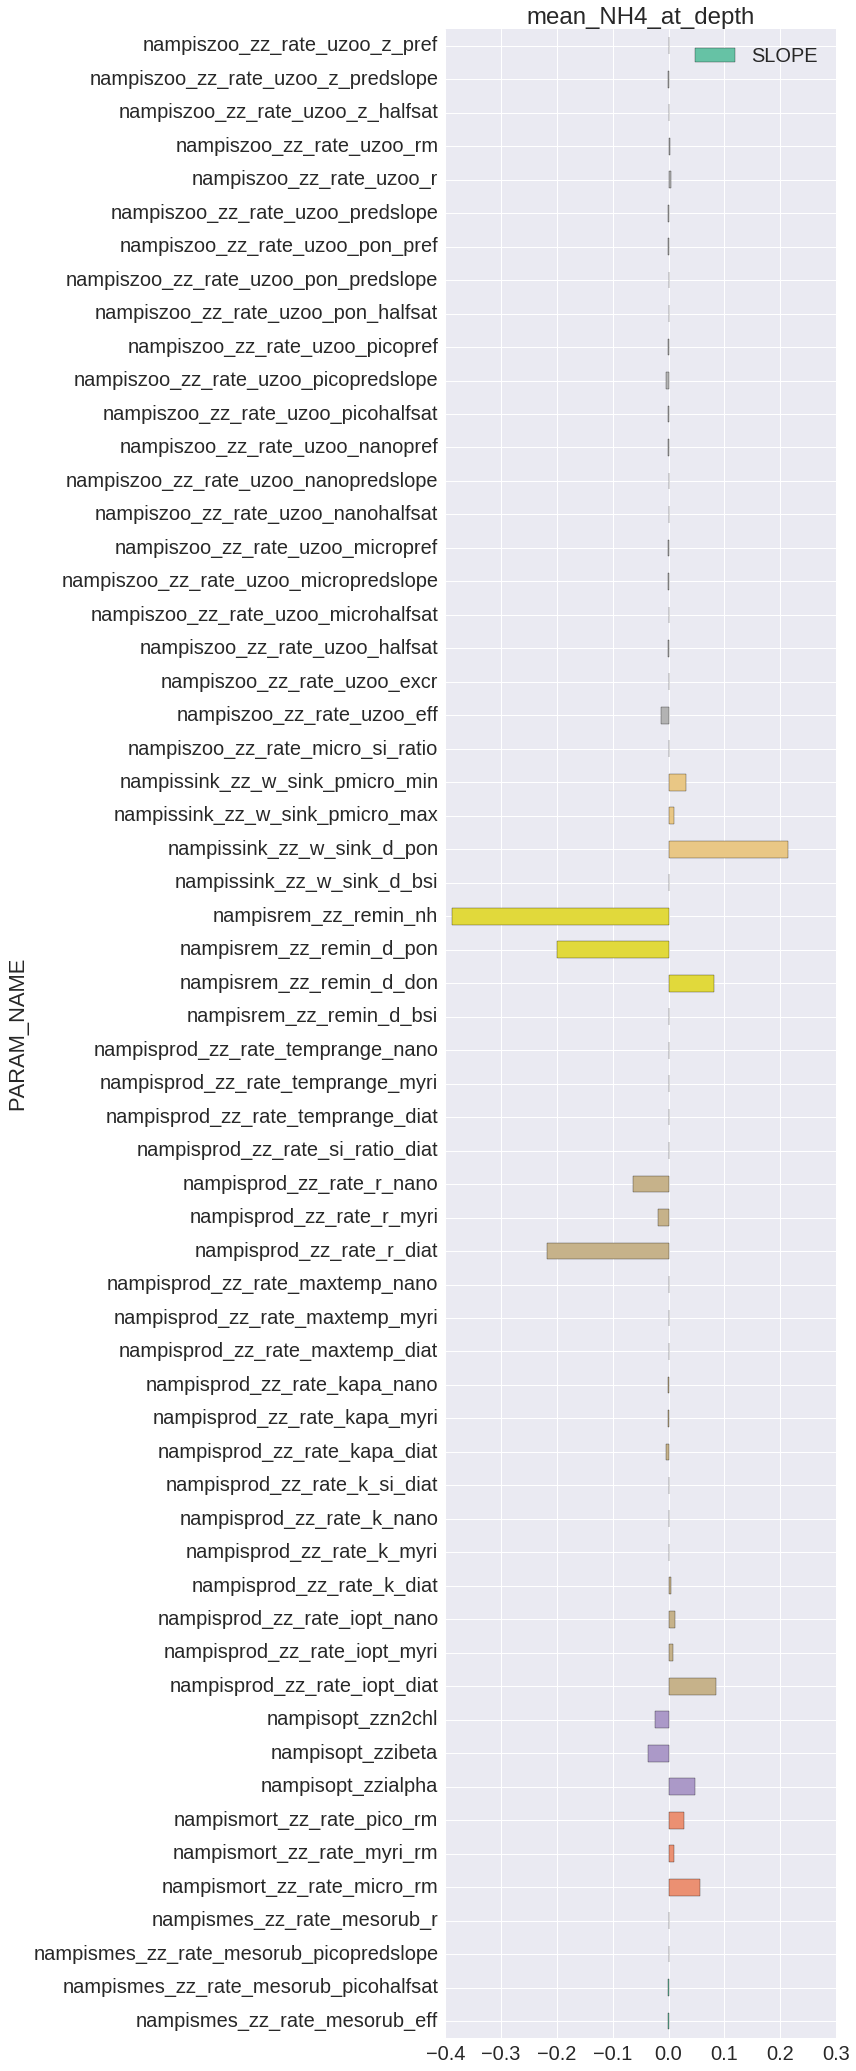

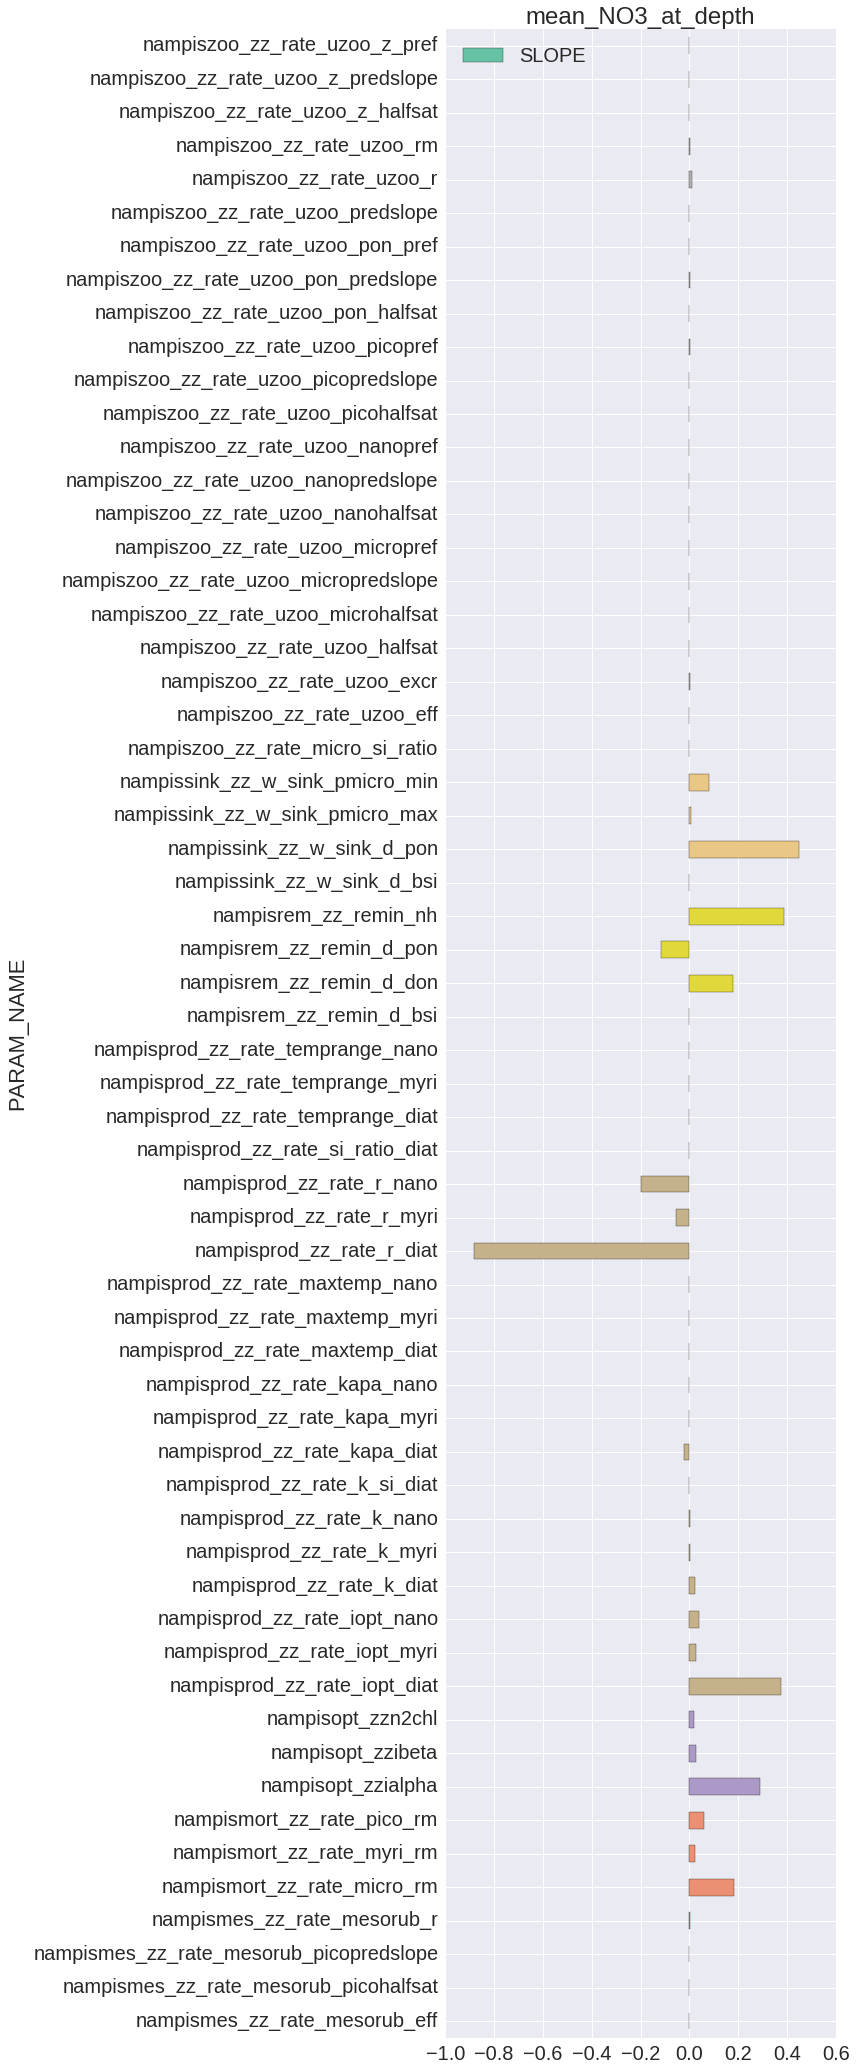

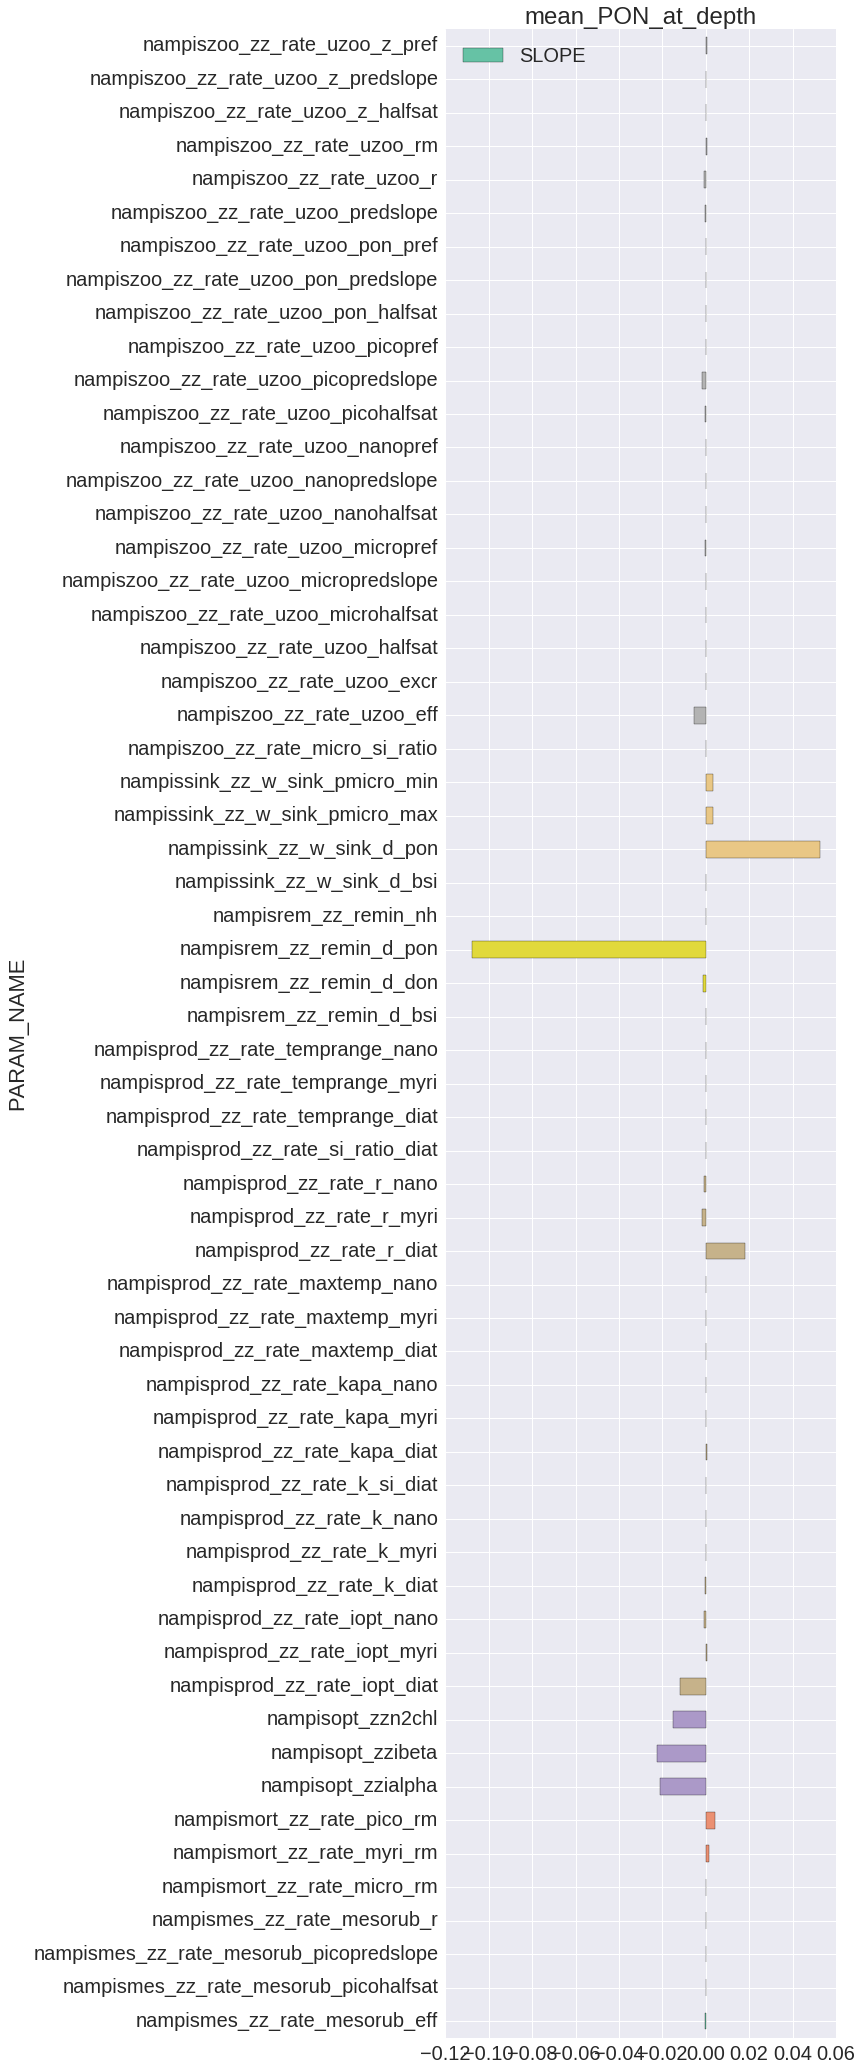

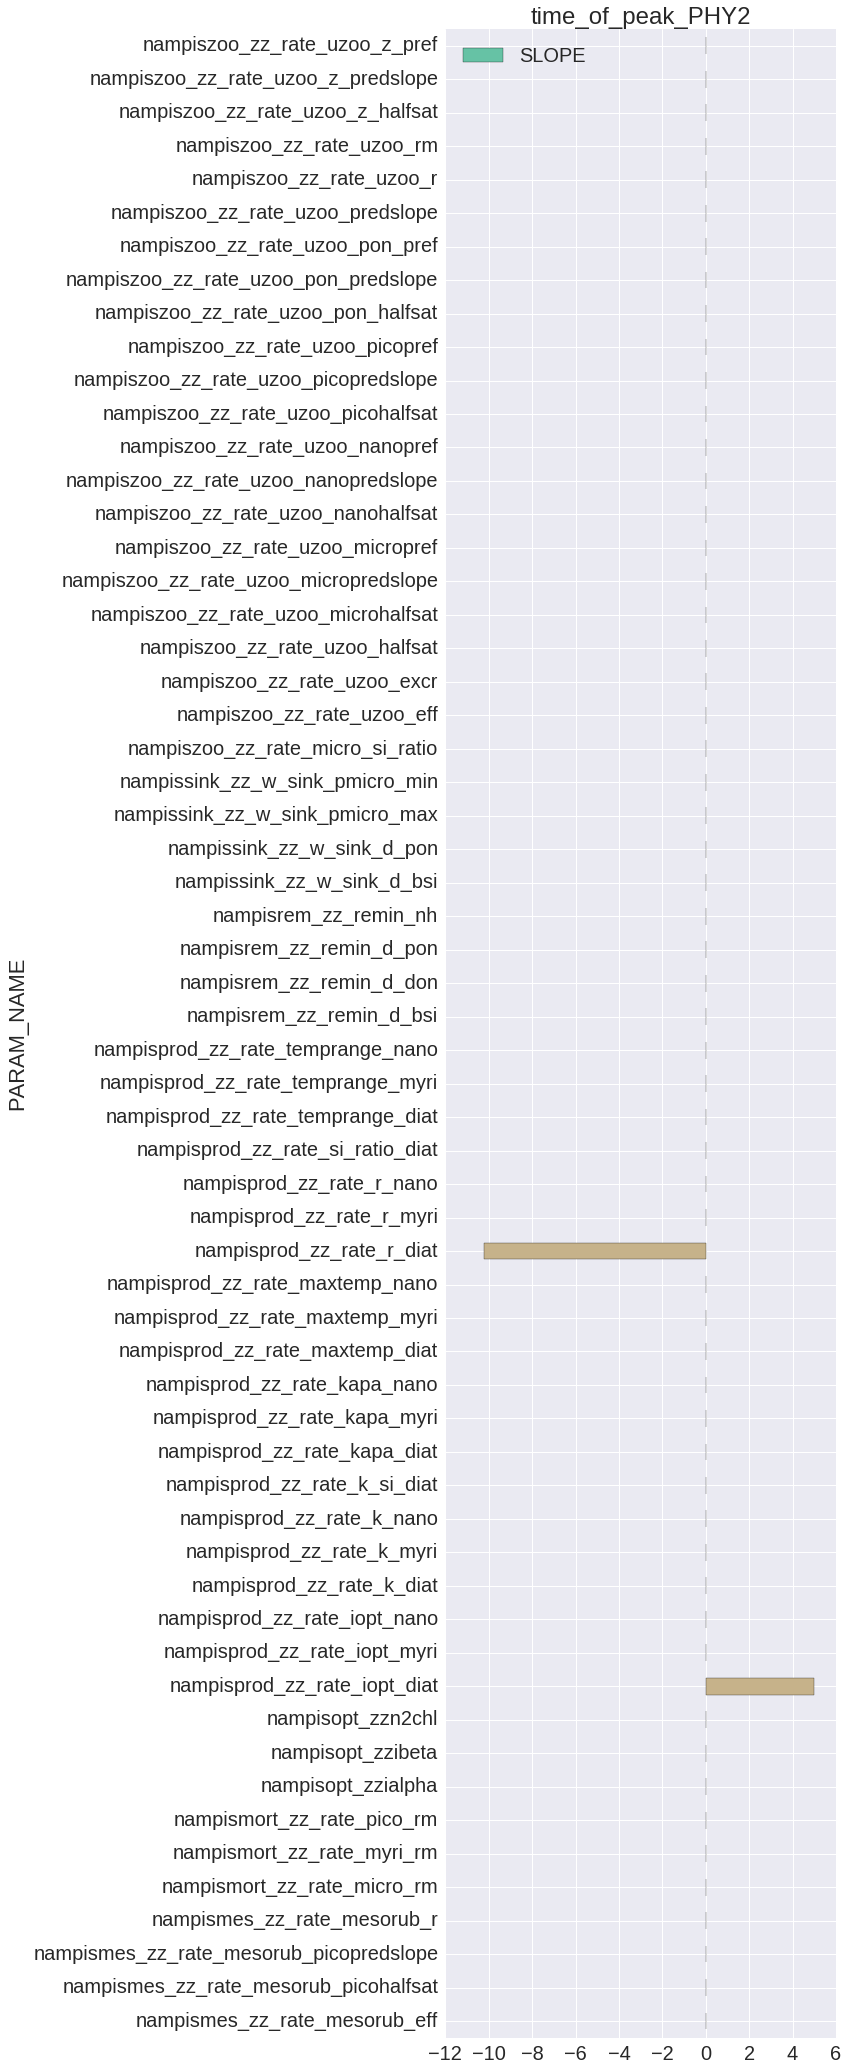

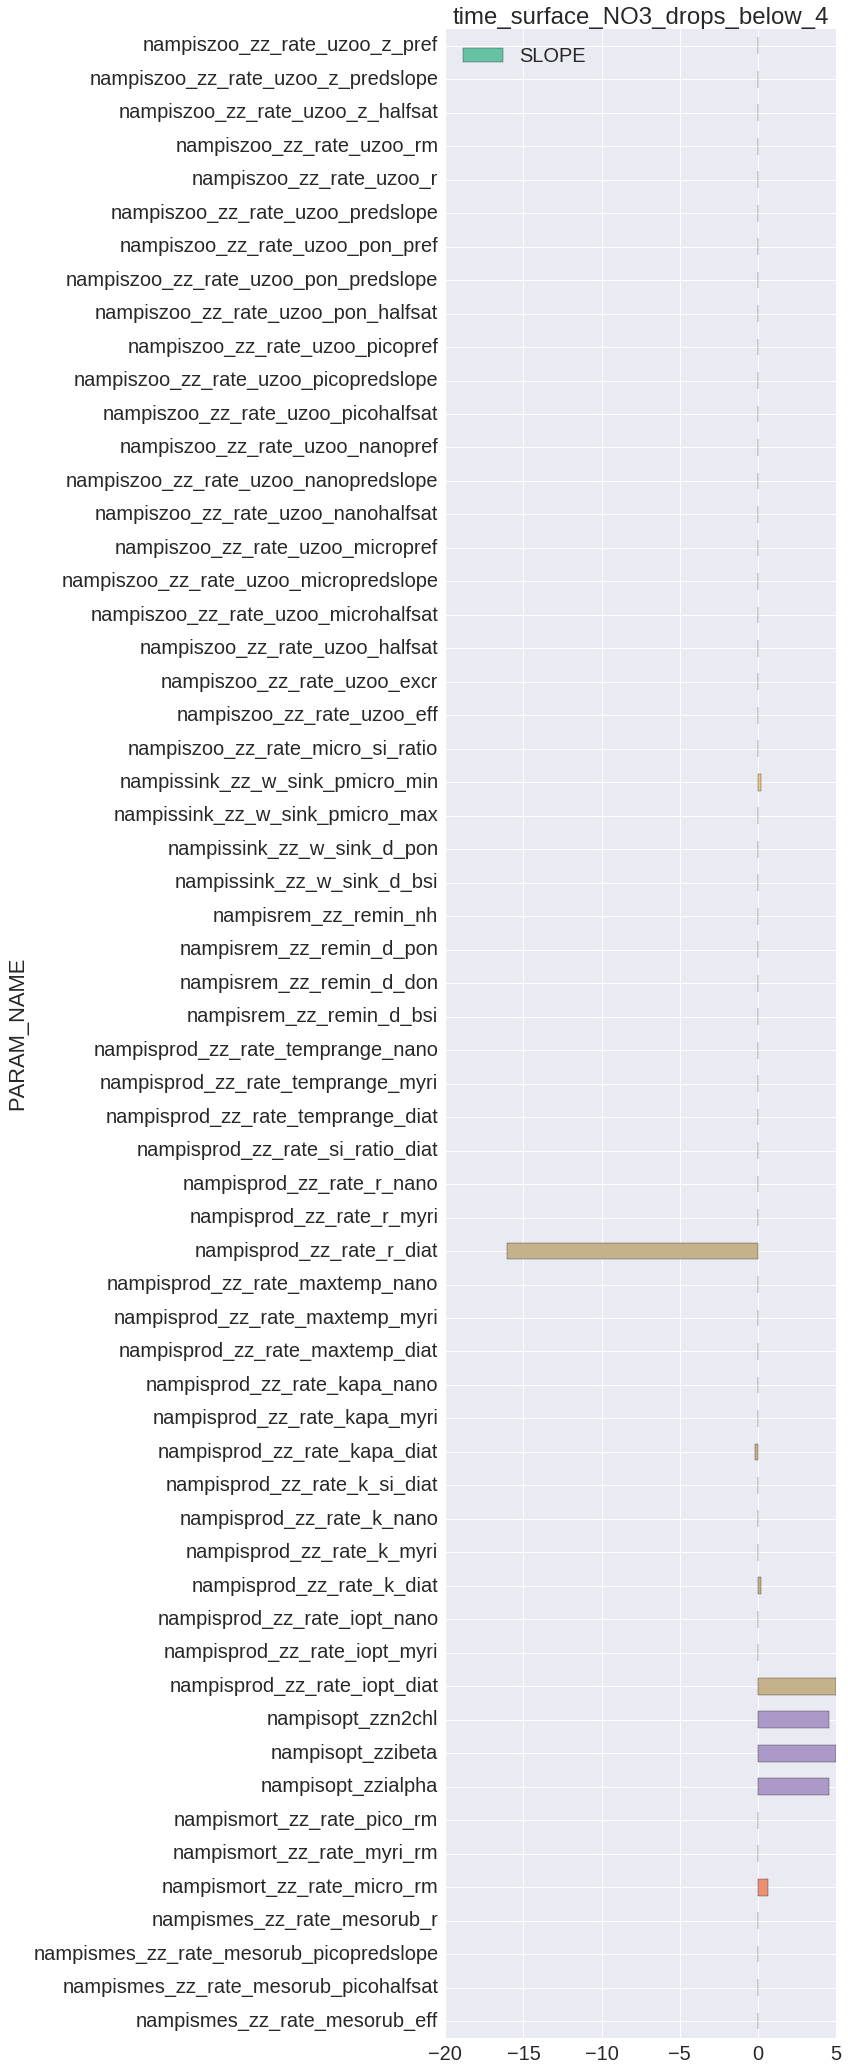

In [13]:
cmap = plt.get_cmap('Set2')
for metric_name in np.unique(wide_format_metrics["METRIC_NAME"]):
    x = wide_format_metrics.query("METRIC_NAME == @metric_name")
    
    categories = np.unique(x["PARAM_SECTION"])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))  
    x["COLOR"] = x["PARAM_SECTION"].apply(lambda x: colordict[x])
    
    x.plot.barh("PARAM_NAME",  "SLOPE", figsize = (7,0.6*len(x["SLOPE"])), color = cmap(x.COLOR), title = metric_name)